In [6]:
# %load calibrate_sine_lmfit_pyemu.py
%matplotlib inline

[[Variables]]
     amp:       5.011593 +/- 0.013966 (0.28%) initial =  10.000000
     decay:     0.024837 +/- 0.000231 (0.93%) initial =  0.100000
     omega:     1.999111 +/- 0.013378 (0.67%) initial =  3.000000
     shift:    -0.106200 +/- 0.016466 (15.50%) initial =  0.000000
[[Correlations]] (unreported correlations are <  0.100)
    C(omega, shift)              = -0.785 
    C(amp, decay)                =  0.584 
    C(amp, shift)                = -0.117 
None
SSR:  12.8161392911


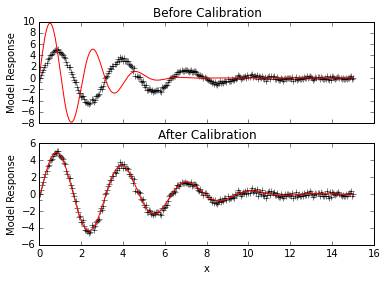

In [11]:
import sys,os
import matk
import numpy as np
from matplotlib import pyplot as plt
from multiprocessing import freeze_support
sys.path.append('/Users/dharp/source-mac/pyemu')
import pyemu
from mat_handler import matrix,cov

# define objective function: returns the array to be minimized
def sine_decay(params, x, data):
    """ model decaying sine wave, subtract data"""
    amp = params['amp']
    shift = params['shift']
    omega = params['omega']
    decay = params['decay']

    model = amp * np.sin(x * omega + shift) * np.exp(-x*x*decay)

    obsnames = ['obs'+str(i) for i in range(1,len(data)+1)]
    return dict(zip(obsnames,model))


# create data to be fitted
x = np.linspace(0, 15, 301)
np.random.seed(1000)
data = (5. * np.sin(2 * x - 0.1) * np.exp(-x*x*0.025) +
        np.random.normal(size=len(x), scale=0.2) )

# Create MATK object
p = matk.matk(model=sine_decay, model_args=(x,data,))

# Create parameters
p.add_par('amp', value=10, min=5., max=15.)
p.add_par('decay', value=0.1, min=0, max=10)
p.add_par('shift', value=0.0, min=-np.pi/2., max=np.pi/2.)
p.add_par('omega', value=3.0, min=0, max=10)

# Create observation names and set observation values
for i in range(len(data)):
    p.add_obs('obs'+str(i+1), value=data[i])

# Look at initial fit
p.forward()
f, (ax1,ax2) = plt.subplots(2,sharex=True)
ax1.plot(x,data, 'k+')
ax1.plot(x,p.simvalues, 'r')
ax1.set_ylabel("Model Response")
ax1.set_title("Before Calibration")

# Calibrate parameters to data, results are printed to screen
lm = p.lmfit(cpus=2)
# Look at calibrated fit
ax2.plot(x,data, 'k+')
ax2.plot(x,p.simvalues, 'r')
ax2.set_ylabel("Model Response")
ax2.set_xlabel("x")
ax2.set_title("After Calibration")
plt.show()

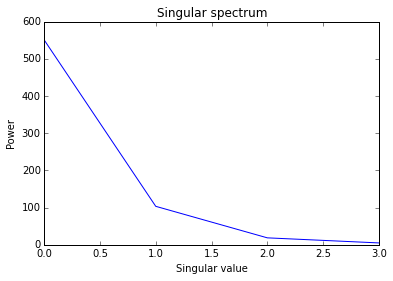


Identifiability of parameters:
amp      0.001426
decay    0.999956
shift    0.998698
omega    0.999919
Name: ident, dtype: float64


In [9]:
# Recompute jacobian at calibration point
J = p.Jac(cpus=2)

# Use pyemu module to analyze identifiability of parameters within calibration 
# Create matrix object of jacobian for pyemu
m = matrix(x=J,row_names=p.obsnames,col_names=p.parnames)
# Create prior parameter covariance matrix using parameter bounds (uniform priors)
parcov_arr = np.array([((mx-mn)/4.)**2 for mx,mn in zip(p.parmaxs,p.parmins)])*np.eye(len(p.pars))
parcov = cov(parcov_arr,names=p.parnames)
# Create prior observation covariance matrix based on observation weights (p.obsweights)
# In this case, it is an identity matrix since all weights are one
obscov_arr = np.eye(len(p.obs))*p.obsweights
obscov = cov(obscov_arr,names=p.obsnames)

# Create pyemu error variance object using jacobian and parameter and observation covariances
#la = pyemu.errvar(jco=m,parcov=parcov,obscov=obscov,forecasts=['obs1'],omitted_parameters=['omega'])
la = pyemu.errvar(jco=m,parcov=parcov,obscov=obscov,forecasts=['obs1'])

# Plot the singular values from the eigenanalysis of the jacobian
s = la.qhalfx.s
plt.title("Singular spectrum")
plt.ylabel("Power")
plt.xlabel("Singular value")
plt.plot(s.x)
plt.show()

# Print identifiability of parameters
# The results indicate that 'amp' has low identifiability relative to other parameters
ident_df = la.get_identifiability_dataframe(3)
print "\nIdentifiability of parameters:"
print ident_df['ident']